## set univariate dependent variable, recession or not, using data with time lag 5

### preprocessing

In [26]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import cross_val_score

In [27]:
 warnings.filterwarnings('ignore')

In [28]:
df=pd.read_csv('univariate_T5.csv')

In [29]:
data_temp=df.values
print(np.shape(data_temp))
print(sum(df.LABEL == True))

(2234, 33)
340


In [30]:
from sklearn.model_selection import train_test_split

X, y = data_temp[:, 1:], data_temp[:, 0]

# set training and test set
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.3, 
                     random_state=0, 
                     stratify=y)
sum(y_test)

102.0

In [31]:
sum(y_train)

238.0

In [32]:
sum(y_test)

102.0

In [33]:
# upsampling
print('Number of recession samples before:',X_train[y_train==1].shape[0])
print('Number of normal samples before:',X_train[y_train==0].shape[0])
X_upsampled, y_upsampled = resample(X_train[y_train==1], y_train[y_train==1],
                                   replace=True,
                                   n_samples = X_train[y_train==0].shape[0],
                                   random_state = 1)
print("Number of recession samples after:", X_upsampled.shape[0])

Number of recession samples before: 238
Number of normal samples before: 1325
Number of recession samples after: 1325


In [34]:
X_train_bal = np.vstack((X_train[y_train==0], X_upsampled))

In [35]:
y_train_bal = np.hstack((y_train[y_train==0], y_upsampled))

In [36]:
print(X_train_bal.shape)
print(y_train_bal.shape)

(2650, 32)
(2650,)


In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [38]:
stdsc = StandardScaler()
X_train_std = stdsc.fit_transform(X_train_bal)
X_test_std = stdsc.transform(X_test)# standardization

### logistics regression

In [39]:
##LR
pipe_lr = make_pipeline(StandardScaler(),
                        PCA(n_components=3),
                        LogisticRegression(random_state=1))

In [40]:
scores = cross_val_score(estimator = pipe_lr,
                        X=X_train_bal,
                        y=y_train_bal,
                        cv=10,
                        scoring='f1',
                        n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.82307692 0.84892086 0.82783883 0.82481752 0.86330935 0.77192982
 0.84285714 0.8137931  0.82909091 0.8172043 ]
CV accuracy: 0.826 +/- 0.023


In [41]:
lr = LogisticRegression(penalty='l2')
lr.fit(X_train_std, y_train_bal)
y_pred_lr2 = lr.predict(X_test_std)

In [42]:
lr.coef_

array([[-0.32721366, -0.14763807, -0.04699084, -0.24687101, -1.26995917,
         0.32582301, -0.40068582, -0.53142713,  0.60529339,  0.20684939,
         0.07297318,  0.44402485, -0.38081856, -0.63095514, -0.55445807,
         0.22645368,  0.40369141,  0.58000144, -0.68431395,  0.48942789,
         0.0650318 , -0.45147264, -0.56323329,  0.73485617,  0.82123897,
         0.49738983,  0.2226928 ,  0.6175677 , -1.67750399, -0.6062247 ,
        -0.10622953, -0.25012486]])

In [43]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred=y_pred_lr2

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

[[443 126]
 [ 12  90]]
Precision: 0.417
Recall: 0.882
F1: 0.566


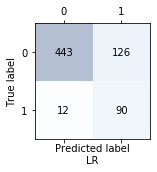

In [44]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label\nLR')
plt.ylabel('True label')

plt.tight_layout()
plt.savefig('Pic', dpi=300)
plt.show()

### Deciision Tree

In [45]:
## Tree Grid Search
from sklearn.model_selection import GridSearchCV
param_grid = {'max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13]}
grid = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid, cv=3, scoring='f1', n_jobs=-1)
gs=grid.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

0.761225860030875
{'max_depth': 7}


In [46]:
tree = DecisionTreeClassifier(criterion='gini', 
                              max_depth=7, 
                              random_state=1)
tree.fit(X_train_std, y_train_bal)
y_pred_tree2 = tree.predict(X_test_std)

In [47]:
scores = cross_val_score(estimator = tree,
                        X=X_train_bal,
                        y=y_train_bal,
                        cv=10,
                        scoring='f1',
                        n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.97416974 0.94623656 0.95652174 0.96703297 0.95306859 0.93617021
 0.94545455 0.94852941 0.96678967 0.93006993]
CV accuracy: 0.952 +/- 0.013


In [50]:
tree.fit(X_train_bal, y_train_bal)
y_pred_tree = tree.predict(X_test)
print('Train Accuracy: %.3f' % tree.score(X_train_bal, y_train_bal))
print('Test Accuracy: %.3f' % tree.score(X_test, y_test))

Train Accuracy: 0.972
Test Accuracy: 0.906


In [51]:
#tree
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred=y_pred_tree2

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

[[527  42]
 [ 20  82]]
Precision: 0.661
Recall: 0.804
F1: 0.726


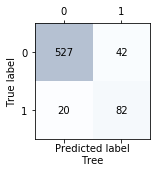

In [52]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label\nTree')
plt.ylabel('True label')

plt.tight_layout()
plt.savefig('Pic', dpi=300)
plt.show()

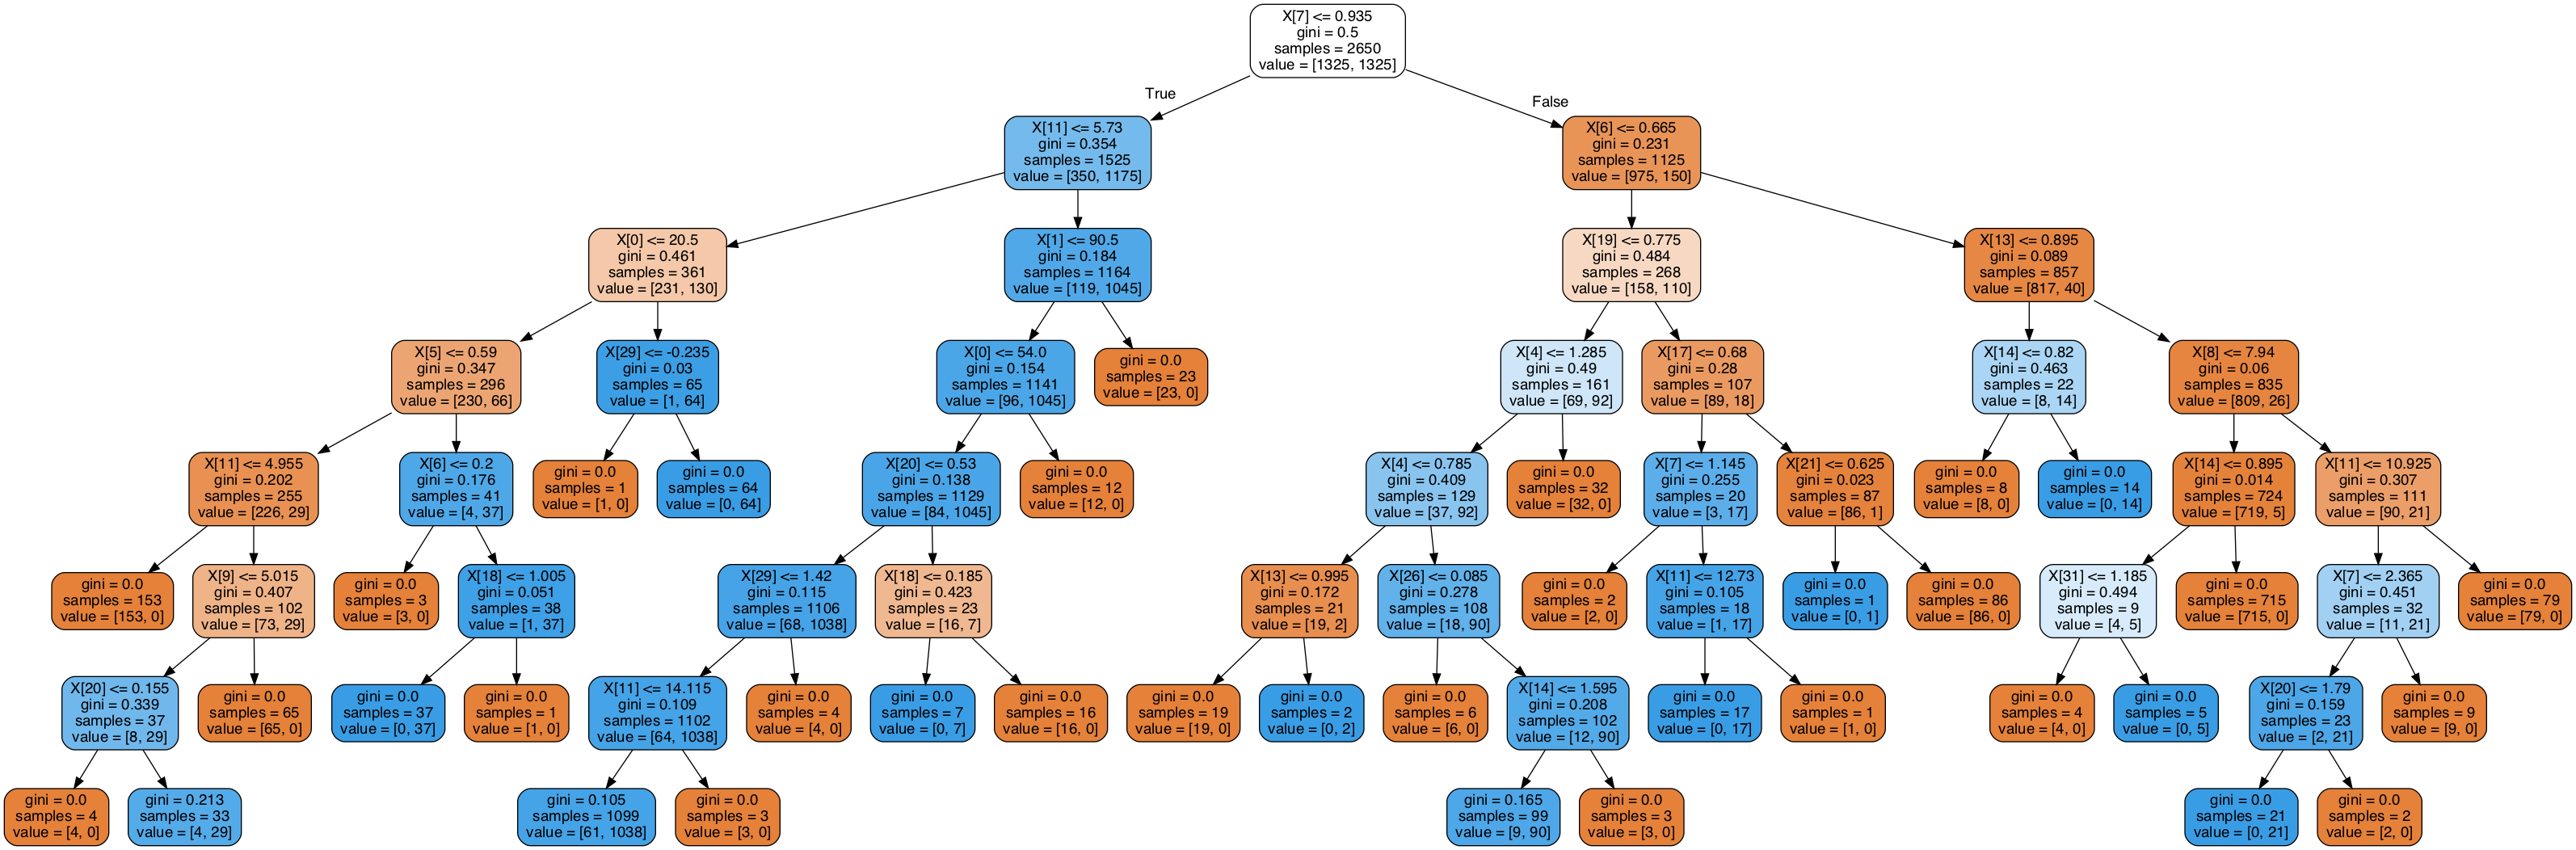

In [53]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree,
                           filled=True, 
                           rounded=True,
                           #class_names=['Setosa', 
                            #            'Versicolor',
                            #            'Virginica'],
                          # feature_names=['petal length', 
                          #                'petal width'],
                           out_file=None) 
graph = graph_from_dot_data(dot_data) 
graph.write_png('Pic/tree_uni5.png')

from IPython.display import Image
Image(filename='Pic/tree_uni5.png', width=600) 

### SVC

In [54]:
## SVC pipeline
pipe_svc = make_pipeline(StandardScaler(),
                        PCA(n_components=3),
                         SVC(kernel='rbf',random_state=1,probability=True))

In [55]:
scores = cross_val_score(estimator = pipe_svc,
                        X=X_train_bal,
                        y=y_train_bal,
                        cv=10,
                        scoring='f1',
                        n_jobs=1)
print('CV accuracy scores: %s' % scores)
print('CV accuracy: %.3f +/- %.3f' % (np.mean(scores), np.std(scores)))

CV accuracy scores: [0.808      0.83969466 0.83969466 0.81679389 0.85393258 0.77205882
 0.85074627 0.80291971 0.83773585 0.81818182]
CV accuracy: 0.824 +/- 0.024


In [56]:
svm = SVC(kernel='rbf', random_state=1, C=0.01, gamma=0.5) #gamma
svm.fit(X_train_std, y_train_bal)
y_pred_svc2 = svm.predict(X_test_std)

In [57]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

y_pred=y_pred_svc2

confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(confmat)

print('Precision: %.3f' % precision_score(y_true=y_test, y_pred=y_pred))
print('Recall: %.3f' % recall_score(y_true=y_test, y_pred=y_pred))
print('F1: %.3f' % f1_score(y_true=y_test, y_pred=y_pred))

[[441 128]
 [ 11  91]]
Precision: 0.416
Recall: 0.892
F1: 0.567


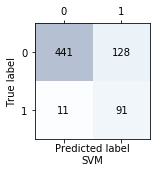

In [60]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

plt.xlabel('Predicted label\nSVM')
plt.ylabel('True label')

plt.tight_layout()
plt.savefig('Pic', dpi=300)
plt.show()

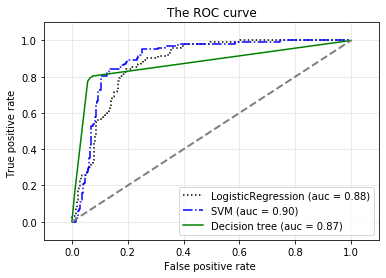

In [62]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
allclf=[pipe_lr,pipe_svc,tree]
labels=['LogisticRegression','SVM','Decision tree']

colors = ['black' , 'blue', 'green']
linestyles = [':' , '-.', '-']
for clf, label, clr, ls \
        in zip(allclf,
               labels, colors, linestyles):


    probas = clf.fit(X_train_bal,
                     y_train_bal).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test,
                                     y_score=probas,pos_label=1)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

    
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.3)
plt.title('The ROC curve')
plt.xlabel('False positive rate ')
plt.ylabel('True positive rate ')


plt.savefig('Pic', dpi=300)
plt.show()

